In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn.neural_network as nn
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, f_regression

In [2]:
datos = pd.read_csv("FOTOSINTESIS.csv", delimiter=";")

In [3]:
datos.head()

,Ano,Cod,Bloque,Altura planta,Area de copa (A) =m2,Diametro tronco (cm),A.F no destructiva m2,P,Asimilacion de CO2,Uso eficiente del agua,...,Conductividad,K,MO,Radiacion,Temperatura,Conductividad electrica,Lluvias acumuladas (mms),Humedad,Numero de dias con lluvia,Total
0,2015,1,1,239.75,4.063267,15.700,10.753787,8.323926,2.36,0.634409,...,0.10,0.169256,2.084278,3086781.006,26.631139,0.017657,1457.3,0.241857,153,991.987500
1,2015,1,2,192.50,5.321635,15.600,7.621132,8.323926,1.73,1.291045,...,0.02,0.169256,2.084278,3086781.006,26.631139,0.017657,1457.3,0.241857,153,540.582500
2,2015,2,2,224.75,7.213035,16.350,13.110679,8.323926,2.72,1.219731,...,0.04,0.169256,2.084278,3086781.006,26.631139,0.017657,1457.3,0.241857,153,267.533333
3,2015,3,2,158.00,2.744031,13.025,3.252769,8.323926,3.20,1.245136,...,0.05,0.169256,2.084278,3086781.006,26.631139,0.017657,1457.3,0.241857,153,1826.063750
4,2015,4,2,196.00,5.925922,16.525,8.810752,8.323926,5.70,1.775701,...,0.07,0.169256,2.084278,3086781.006,26.631139,0.017657,1457.3,0.241857,153,586.963500


In [4]:
print(datos.shape)

(428, 21)


In [5]:
datos = datos.fillna(datos.mean())

In [6]:
datos = datos.drop(['Ano','Cod','Bloque'], axis=1)

In [7]:
cols_to_norm = ['Altura planta','Area de copa (A) =m2', 'Diametro tronco (cm)','A.F no destructiva m2','P','Asimilacion de CO2','Uso eficiente del agua','Transpiracion','Conductividad','K','MO','Radiacion','Temperatura','Conductividad electrica','Lluvias acumuladas (mms)','Humedad',' Numero de dias con lluvia','Total']
datos[cols_to_norm] = datos[cols_to_norm].apply(lambda X: (X - X.min()) / (X.max() - X.min()))

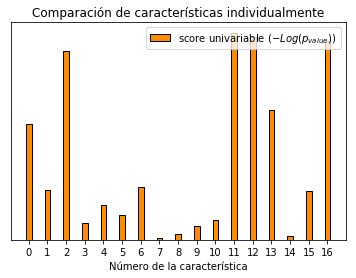

In [8]:
selector = SelectPercentile(f_regression, percentile=10)
selector.fit(datos.values[:,:-1], datos.values[:,-1])
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
X_indices = np.arange(datos.values[:,:-1].shape[-1])
plt.bar(X_indices, scores, width=.3,
        label=r'score univariable ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black');

plt.xticks(np.arange(20))
plt.title("Comparación de características individualmente")
plt.xlabel('Número de la característica')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [9]:
scores[:]

array([0.55757013, 0.24148548, 0.91254017, 0.07998632, 0.16672941,
       0.11987173, 0.25430725, 0.01048338, 0.03014412, 0.06818754,
       0.09749354, 1.        , 0.97902927, 0.62512066, 0.01967284,
       0.23548382, 0.96197681])

In [10]:
datos = datos.drop(['Area de copa (A) =m2','A.F no destructiva m2','P','Asimilacion de CO2','Uso eficiente del agua','Transpiracion','Conductividad','K','MO','Humedad','Lluvias acumuladas (mms)'], axis=1)

In [11]:
datos.head()

,Altura planta,Diametro tronco (cm),Radiacion,Temperatura,Conductividad electrica,Numero de dias con lluvia,Total
0,0.485969,0.315053,0.404994,0.980408,0.050663,0.666667,0.081196
1,0.244898,0.310385,0.404994,0.980408,0.050663,0.666667,0.042171
2,0.409439,0.345391,0.404994,0.980408,0.050663,0.666667,0.018566
3,0.068878,0.190198,0.404994,0.980408,0.050663,0.666667,0.153303
4,0.262755,0.353559,0.404994,0.980408,0.050663,0.666667,0.046181


In [12]:
X = datos.values[:,:-1]  
Y = datos.values[:,-1]
names=datos.columns

In [13]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [14]:
# hacer validación cruzada
kf = KFold(n_splits=5,random_state=0, shuffle=True)
kf.get_n_splits(X)

5

In [15]:
#CON VALIDACIÓN CRUZADA

R = []
MSE = []   
MAE = []   
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    mlp = nn.MLPRegressor(solver='adam', hidden_layer_sizes=10, max_iter=100, activation='relu', random_state=1, learning_rate_init=0.025, batch_size='auto', momentum=0.09)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print("R2: ", r2)
    print("MSE: ", mse)
    print("RMSE: ", np.sqrt(mse))
    print('MAE: ', mae)
    R.append(r2)
    MSE.append(mse)
    MAE.append(mae)
print("meanR2: ",np.array(R).mean())
print("meanMSE: ",np.array(MSE).mean())
print("meanRMSE: ", np.sqrt(MSE).mean())
print('meanMAE: ',np.array(MAE).mean())

R2:  0.22534178674708893
MSE:  0.023179322632533084
RMSE:  0.15224757020239463
MAE:  0.11185941671284612
R2:  0.15351854209259763
MSE:  0.018724374974068203
RMSE:  0.13683703801993158
MAE:  0.10537417457816792
R2:  0.05238533608288498
MSE:  0.019175619618811642
RMSE:  0.1384760615370456
MAE:  0.11019956929206348
R2:  0.16596525016346841
MSE:  0.0257858123546315
RMSE:  0.1605796137578849
MAE:  0.10873688685810247
R2:  0.09988652545097543
MSE:  0.014254530583148862
RMSE:  0.1193923388796319
MAE:  0.09321878981880292
meanR2:  0.13941948810740307
meanMSE:  0.02022393203263866
meanRMSE:  0.1415065244793777
meanMAE:  0.10587776745199658
